In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import sys
import os
import re
import random

from time import time
from tqdm import tqdm

from contextlib import contextmanager
import lightgbm as lgb

In [ ]:
#上限表示数を拡張
pd.set_option('display.max_columns', 10000)
pd.set_option('display.max_rows', 200)

In [ ]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

In [ ]:
INPUT = "/content/drive/MyDrive/nishika/" # 所望のディレクトリに変更してください。
train_df = pd.read_csv(os.path.join(INPUT, "train.csv"))
test_df = pd.read_csv(os.path.join(INPUT, "test.csv"))
submission_df = pd.read_csv(os.path.join(INPUT, "sample_submission.csv"))

In [ ]:
df_1_tr = pd.read_csv("/content/drive/MyDrive/nishika/output/train_SwinTransformerLarge384_V2Large256.csv")
df_1_ts = pd.read_csv("/content/drive/MyDrive/nishika/output/test_SwinTransformerLarge384_V2Large256.csv")

In [ ]:
df_2_tr = pd.read_csv("/content/drive/MyDrive/nishika/output/train_efb2_rinnabase.csv")
df_2_ts = pd.read_csv("/content/drive/MyDrive/nishika/output/test_efb2_rinnabase.csv")

In [ ]:
df_3_tr = pd.read_csv("/content/drive/MyDrive/nishika/output/train_swinv2base256_ginza510electra.csv")
df_3_ts = pd.read_csv("/content/drive/MyDrive/nishika/output/test_swinv2base256_ginza510electra.csv")

In [ ]:
df_4_tr = pd.read_csv("/content/drive/MyDrive/nishika/output/train_efv2b2_resnet152_jaginza.csv")
df_4_ts = pd.read_csv("/content/drive/MyDrive/nishika/output/test_efv2b2_resnet152_jaginza.csv")

In [ ]:
#swinL384,swinV2L256,Roberta-text,
df_tmp_tr_1 = pd.concat([df_1_tr,df_2_tr],axis=1)
df_tmp_ts_1 = pd.concat([df_1_ts,df_2_ts],axis=1)

In [ ]:
#Efficientnetb2
df_tmp_tr_2 = pd.concat([df_tmp_tr_1,df_2_tr],axis=1)
df_tmp_ts_2 = pd.concat([df_tmp_ts_1,df_2_ts],axis=1)

In [ ]:
#ginza510-electra-base-text,swinv2base256
df_tmp_tr_3 = pd.concat([df_tmp_tr_2,df_3_tr],axis=1)
df_tmp_ts_3 = pd.concat([df_tmp_ts_2,df_3_ts],axis=1)

In [ ]:
#efficientnetv2b2,resnet152,jaginza(ginza_electra_text)
df_tmp_tr_4 = pd.concat([df_tmp_tr_3,df_4_tr],axis=1)
df_tmp_ts_4 = pd.concat([df_tmp_ts_3,df_4_ts],axis=1)

In [ ]:
train_emb = df_tmp_tr_4.drop(["is_laugh","odai_photo_file_name"], axis=1)

In [ ]:
test_emb = df_tmp_ts_4.drop(["odai_photo_file_name"], axis=1)

In [ ]:
print(test_emb)

      SwinTransformerLarge384_0  SwinTransformerLarge384_1  \
0                      0.011191                   0.275341   
1                     -0.024547                   0.029456   
2                     -0.143125                   0.043243   
3                     -0.120009                   0.147455   
4                     -0.001404                  -0.054568   
...                         ...                        ...   
5995                  -0.080366                  -0.381103   
5996                  -0.295183                  -0.309611   
5997                   0.181993                  -0.006894   
5998                   0.887106                  -0.051393   
5999                   0.100449                   0.035295   

      SwinTransformerLarge384_2  SwinTransformerLarge384_3  \
0                      0.305003                  -0.200251   
1                     -0.164185                  -0.184940   
2                      0.175950                  -0.256117   
3      

In [ ]:
train = pd.concat([train_emb,train_df],axis=1)
test = pd.concat([test_emb,test_df],axis=1)

In [ ]:
# 学習データと評価データに分割します
train, valid = train_test_split(train, test_size=0.2, random_state=42, stratify=train["is_laugh"])

train_y = train["is_laugh"]
train_x = train.drop(["odai_photo_file_name","is_laugh","id","text"], axis=1)

valid_y = valid["is_laugh"]
valid_x = valid.drop(["odai_photo_file_name","is_laugh","id","text"], axis=1)

test_x = test.drop(["odai_photo_file_name","id","text"], axis=1)

In [ ]:
print(train_x.shape)
print(valid_x.shape)

(19969, 5199)
(4993, 5199)


In [ ]:
train_x = train_x.T.drop_duplicates().T
valid_x = valid_x.T.drop_duplicates().T 
test_x = test_x.T.drop_duplicates().T 

# Model

In [ ]:
lgbm_params = {  
    "n_estimators": 20000,
    "objective": 'binary',
    "learning_rate": 0.05,
    "num_leaves": 32,
    "random_state": 71,
    "n_jobs": -1,
    "importance_type": "gain",
    'colsample_bytree': .8,
    "reg_lambda": 5,
    "max_depth":5,
    }

lgtrain = lgb.Dataset(train_x, train_y)
lgvalid = lgb.Dataset(valid_x, valid_y)

lgb_clf = lgb.train(
    lgbm_params,
    lgtrain,
    num_boost_round=10000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train','valid'],
    early_stopping_rounds=100,
    verbose_eval=100
)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[100]	train's binary_logloss: 0.544627	valid's binary_logloss: 0.651088
[200]	train's binary_logloss: 0.469261	valid's binary_logloss: 0.648696
[300]	train's binary_logloss: 0.412296	valid's binary_logloss: 0.648619
[400]	train's binary_logloss: 0.364149	valid's binary_logloss: 0.648485
Early stopping, best iteration is:
[331]	train's binary_logloss: 0.395665	valid's binary_logloss: 0.647563


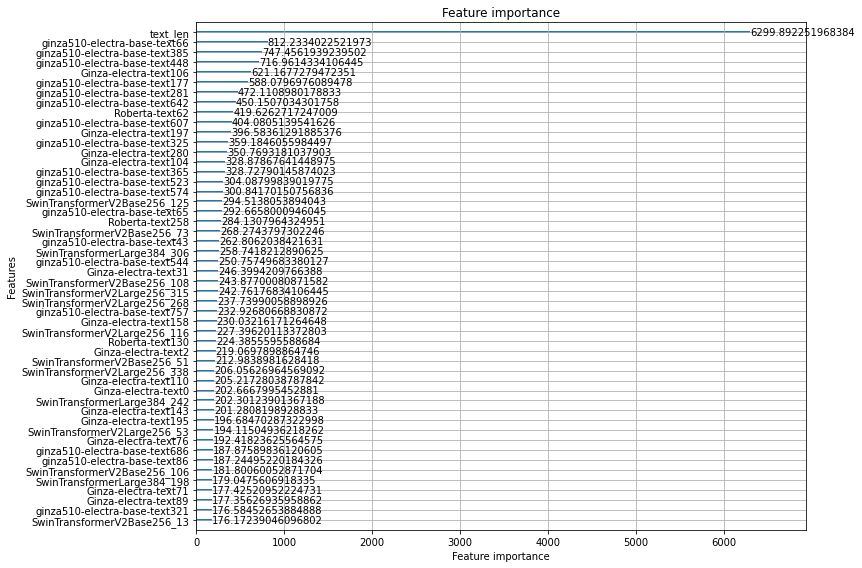

In [ ]:
# 特徴量の重要度を可視化。
lgb.plot_importance(lgb_clf, figsize=(12,8), max_num_features=50, importance_type='gain')
plt.tight_layout()
plt.show()

In [ ]:
# 評価指標はlog lossだが、accuracyも見てみる

val_pred = lgb_clf.predict(valid_x, num_iteration=lgb_clf.best_iteration)
val_pred_max = np.round(lgb_clf.predict(valid_x)).astype(int)  # クラスに分類
accuracy = sum(valid_y == val_pred_max) / len(valid_y)
print(accuracy)

0.6278790306429001


Text(0.5, 51.0, 'Predict')

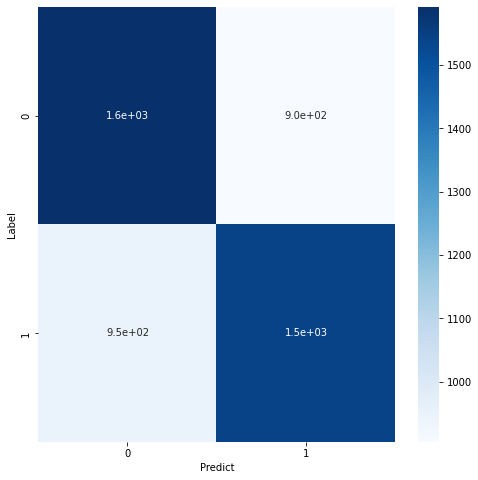

In [ ]:
_conf_options = {"normalize": None,}
_plot_options = {
        "cmap": "Blues",
        "annot": True
    }

conf = confusion_matrix(y_true=valid_y,
                        y_pred=val_pred_max,
                        **_conf_options)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf, ax=ax, **_plot_options)
ax.set_ylabel("Label")
ax.set_xlabel("Predict")

# Predict

In [ ]:
test_pred = lgb_clf.predict(test_x, num_iteration=lgb_clf.best_iteration)

In [ ]:
submission_df["is_laugh"] = test_pred
submission_df.head()

,id,is_laugh
0,rfdjcfsqq,0.409010
1,tsgqmfpef,0.399586
2,owjcthkz2,0.268519
3,rvgaocjyy,0.510924
4,uxtwu5i69,0.700085


In [ ]:
submission_df.to_csv(('sub.csv'), index=False)

実際に提出して、スコアを確認してみましょう。  精度向上に向けて様々なアイディアがあるかと思いますので、ぜひいろいろとトライしていただければと思います！

- 異なる学習済みモデルでの特徴量化
- 画像の状況とボケての文章との解離具合を測定する
- 説明文口調とセリフ口調の分類をしてみる。
- 画像に何が写っているかを検出し、特徴量に加えてみる（人が写っている。動物が写っている）


https://lab.mo-t.com/blog/kaggle-shopee
前処理については今回は気にしない。最終的なLightgbmにぶっこむ特徴量を増やして選別する方針でいく。
エンベッディングした結果は保存する。
最初は画像は画像、テキストはテキストでエンベッディングする。
画像のArcFaceちょっとめんどい、実装できそうならやる
knn(k=50)を使って、画像、テキストの分類自体はする。
https://www.kaggle.com/code/jyotmakadiya/shopee-groupkfolds-effnetb1-and-tfidf-or-bert

基本はエンベッディングしたものを使う。
プラスで、特徴量を足してみる。
乖離具合ってどうやって測定するのか
・長文？なんかキーになる話がある？画像と関係？わからん
・ボケのデザインパターン/ジョナサン・ハイト
・既知未知判定ってどうやってやるんだ・・・
・ポジネガ距離はおもろい。
あえて正しいこととは逆なことをして、許されるライン的な話。
→単純にえぐい言葉やえぐさを分類？なんかいいのないかな。
説明文とセリフ文→なんかいい楽な分類ないかな、なかったら頑張る。
画像に何が写っているか→うーん、手動しかないかも。